In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gekko import GEKKO

from scipy.signal import savgol_filter

In [2]:
czantoria_full = pd.read_csv('data/csv/czantoria_sauce.csv')
czantoria_full.columns = ['time', 'distance', 'heartrate', 'cadence', 'velocity_smooth', 'altitude', 'grade_smooth']
czantoria_nonzero = czantoria_full[(czantoria_full['velocity_smooth'] > 0) | (czantoria_full['time'] == 0)]
czantoria_time = czantoria_nonzero.groupby('distance').agg({'time': 'max'}).reset_index()['time']
czantoria_final = pd.merge(czantoria_nonzero, czantoria_time, on=['time'])

In [3]:
distance_data = czantoria_final['distance'].to_numpy()
grade_data = czantoria_final['grade_smooth'].to_numpy()
elevation_data = czantoria_final['altitude'].to_numpy()

In [4]:
grade_smooth = savgol_filter(grade_data, 501, 1)

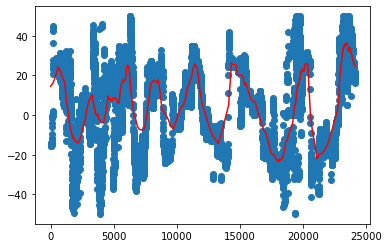

In [5]:
plt.scatter(distance_data, grade_data)
plt.plot(distance_data, grade_smooth, 'r')

In [6]:
# grade_data = np.arctan(grade_data/100)
# yhat = np.arctan(grade_smooth/100)
# plt.scatter(distance_data, grade_data)
# plt.plot(distance_data, yhat, 'r')

In [7]:
grade_data = grade_smooth

print(len(grade_data))

n = distance_data.shape[0]
to_stay = np.zeros(n)
to_stay[0] = 1

for i in range(n - 1):
    if np.abs(grade_data[i+1] - grade_data[i]) < 1.5:
        grade_data[i+1] = grade_data[i]
        to_stay[i+1] = 0
    elif np.sign(grade_data[i+1]) != np.sign(grade_data[i]):
        to_stay[i + 1] = 1
    else:
        to_stay[i + 1] = 1
        
to_stay[-1] = 1

grade_data = grade_data[to_stay == 1]
distance_data = distance_data[to_stay == 1]
elevation_data = elevation_data[to_stay == 1]

print(len(grade_data))

grade_data = np.arctan(grade_data/100)

13385
335


In [8]:
distance = distance_data[-1]

x_data = distance_data/(distance_data[-1])
slope_data = grade_data

# x_data = x_data[x_data <= distance]
# slope_data = slope_data[x_data <= distance]

In [9]:
# create GEKKO model
m = GEKKO()

In [10]:
t_est = 4 * 60 * 60
t_min = 1 * 60 * 60
t_max = 20 * 60 * 60

In [11]:
# constants
N_m = 0.0222
E0 = 1400
X = distance
tau = 0.67
g = 9.81
k = 0.03734
mass = 55
S = 22

In [12]:
# equation parts
alpha = (np.sqrt(S/tau) * X)/E0
beta = (4 * 4184 * 1/75 * N_m * X)/(E0 * np.sqrt(S * tau))
gamma = X/np.sqrt(S * tau**3)
delta = (g*X)/(S*tau)
mu = (k*N_m*X)/(np.sqrt(S*tau))

In [13]:
# scales
u_scale = np.sqrt(S/tau)
v_scale = np.sqrt(S*tau)
t_scale = X/v_scale

In [14]:
# scaled values
sigma0 = 1
e0 = 1
x0 = 0
v0 = 0
n0 = 0.00201818/N_m

e_crit = 0.15 * e0

In [15]:
# sigma data to create spline
# E_data = np.linspace(0, e0, 1001)
# sigma_data = sigma0 * E_data/(e0 * e_crit) + 0.75 * sigma0 * (1 - E_data/(e0 * e_crit))
# sigma_data[E_data > e_crit] = sigma0

# slope data to create spline
# x_data = np.linspace(0, 1, 3000)
# slope_data = np.array(600*[1/18 * np.pi] + 600 * [-1/18 * np.pi] + 600*[1/36 * np.pi] + 600 * [-1/36 * np.pi] + 600 * [1/9 * np.pi])

In [16]:
# time points [s]
nt = 201
tm = np.linspace(0,1,nt)
m.time = tm

In [17]:
# Variables
v = m.Var(value=0.0, lb=0.0, ub=6/v_scale) #velocity
E = m.Var(value=e0, lb=0.0, ub=e0) #energy
x = m.Var(value=0.0) #horizontal coordinate
N = m.Var(value=n0, lb=0.0) # oxidation rate

sigma = m.Const(value=sigma0) #breathing rate
slope = m.Var(value=slope_data[0]) #slope

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

In [18]:
# FV - final time
# tf = m.FV(value=t_est/t_scale,lb=t_min/t_scale,ub=t_max/t_scale)
tf = m.FV(value=t_est/t_scale, lb = 0.1)
tf.STATUS = 1

In [19]:
# MV
u = m.MV(value=0,lb=0,ub=9.6/u_scale)
u.STATUS = 1

In [20]:
# energy decrease at the end
# m.cspline(E, sigma, E_data, sigma_data, True)

# slope
m.cspline(x, slope, x_data, slope_data, True)

In [21]:
# equations
m.Equation(E.dt()==(alpha * (sigma - u * v) + beta * N)*tf)
m.Equation(v.dt()==(gamma * (u - v) - delta * m.sin(slope)) * tf)
m.Equation(x.dt()==(v*m.cos(slope))*tf)
m.Equation(N.dt()==(mu * N * (1 - N))*tf)
# m.Equation(alpha * (sigma - u * v) + beta * N <= 0)
m.Equation((distance - X*x)*final<=0)

m.fix_final(E, 0)

In [22]:
m.options.IMODE = 6
m.options.MAX_ITER=30000
m.options.SOLVER=3
# m.options.RTOL=1e-4
# m.options.OTOL=1e-4

m.solve()

print('Final Time: ' + str(tf.value[0] * t_scale))

tm = tm * tf.value[0] * t_scale

apm 80.253.213.10_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            1
   Constants    :            1
   Variables    :            9
   Intermediates:            0
   Connections  :            4
   Equations    :            5
   Residuals    :            5
 
 Number of state variables:           2999
 Number of total equations: -         2800
 Number of slack variables: -          200
 ---------------------------------------
 Degrees of freedom       :             -1
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This 

  96r 2.0091748e-02 1.93e+04 1.13e+03   1.3 2.46e-02   4.7 1.00e+00 1.00e+00f  1
  97r 2.0222823e-02 1.93e+04 1.08e+03   1.3 7.03e-02   4.2 1.00e+00 1.00e+00f  1
  98r 2.0608157e-02 1.93e+04 1.07e+03   1.3 2.10e-01   3.7 1.00e+00 1.00e+00f  1
  99r 2.0751647e-02 1.93e+04 4.15e+03   1.3 1.41e-01   4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 2.0805311e-02 1.93e+04 1.21e+04   1.3 6.25e-02   4.6 1.00e+00 1.00e+00f  1
 101r 2.0825415e-02 1.93e+04 1.77e+03   1.3 1.14e-02   5.0 1.00e+00 1.00e+00f  1
 102r 2.0885541e-02 1.93e+04 1.06e+03   1.3 3.27e-02   4.5 1.00e+00 1.00e+00f  1
 103r 2.1064288e-02 1.93e+04 1.07e+03   1.3 9.96e-02   4.0 1.00e+00 1.00e+00f  1
 104r 2.1131097e-02 1.93e+04 1.13e+03   1.3 3.94e-02   4.5 1.00e+00 1.00e+00f  1
 105r 2.1329532e-02 1.93e+04 1.28e+03   1.3 1.18e-01   4.0 1.00e+00 1.00e+00f  1
 106r 2.1403677e-02 1.93e+04 1.14e+03   1.3 4.46e-02   4.4 1.00e+00 1.00e+00f  1
 107r 2.1407152e-02 1.93e+04

 234r 2.6775290e-02 1.93e+04 1.15e+03   1.3 2.06e-02   4.7 1.00e+00 1.00e+00f  1
 235r 2.6785297e-02 1.93e+04 1.20e+03   1.3 8.10e-03   5.2 1.00e+00 1.00e+00f  1
 236r 2.6815282e-02 1.93e+04 1.12e+03   1.3 2.25e-02   4.7 1.00e+00 1.00e+00f  1
 237r 2.6826521e-02 1.93e+04 1.17e+03   1.3 8.83e-03   5.1 1.00e+00 1.00e+00f  1
 238r 2.6860192e-02 1.93e+04 1.27e+03   1.3 2.88e-02   4.6 1.00e+00 1.00e+00f  1
 239r 2.6861771e-02 1.93e+04 5.17e+03   1.3 2.29e-03   6.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r 2.6866504e-02 1.93e+04 1.45e+03   1.3 4.62e-03   5.5 1.00e+00 1.00e+00f  1
 241r 2.6880697e-02 1.93e+04 1.10e+03   1.3 1.06e-02   5.0 1.00e+00 1.00e+00f  1
 242r 2.6923202e-02 1.93e+04 4.96e+03   1.3 5.34e-02   4.5 1.00e+00 1.00e+00f  1
 243r 2.6925194e-02 1.93e+04 6.91e+03   1.3 1.30e-02   5.9 1.00e+00 1.00e+00f  1
 244r 2.6925941e-02 1.93e+04 3.66e+04   1.3 1.85e-02   6.3 1.00e+00 1.00e+00f  1
 245r 2.6928182e-02 1.93e+04

 371r 3.1797952e-02 1.93e+04 1.11e+03   1.3 5.47e-03   5.3 1.00e+00 1.00e+00f  1
 372r 3.1816121e-02 1.93e+04 1.17e+03   1.3 1.73e-02   4.8 1.00e+00 1.00e+00f  1
 373r 3.1822932e-02 1.93e+04 1.39e+03   1.3 7.72e-03   5.3 1.00e+00 1.00e+00f  1
 374r 3.1843352e-02 1.93e+04 1.14e+03   1.3 1.89e-02   4.8 1.00e+00 1.00e+00f  1
 375r 3.1851007e-02 1.93e+04 1.22e+03   1.3 7.61e-03   5.2 1.00e+00 1.00e+00f  1
 376r 3.1873954e-02 1.93e+04 1.10e+03   1.3 2.06e-02   4.7 1.00e+00 1.00e+00f  1
 377r 3.1882557e-02 1.93e+04 1.13e+03   1.3 7.97e-03   5.2 1.00e+00 1.00e+00f  1
 378r 3.1908340e-02 1.93e+04 1.19e+03   1.3 2.50e-02   4.7 1.00e+00 1.00e+00f  1
 379r 3.1918005e-02 1.93e+04 1.70e+03   1.3 1.34e-02   5.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r 3.1921629e-02 1.93e+04 2.14e+03   1.3 7.45e-03   5.5 1.00e+00 1.00e+00f  1
 381r 3.1932497e-02 1.93e+04 1.19e+03   1.3 1.06e-02   5.1 1.00e+00 1.00e+00f  1
 382r 3.1936572e-02 1.93e+04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510r 3.5301634e-02 1.93e+04 5.69e+06   1.3 1.75e+00   5.8 1.00e+00 1.00e+00f  1
 511r 3.5301635e-02 1.93e+04 1.35e+08   1.3 6.36e-02   9.0 1.00e+00 1.00e+00f  1
 512r 3.5301639e-02 1.93e+04 4.50e+06   1.3 4.01e-03   8.5 1.00e+00 1.00e+00f  1
 513r 3.5301639e-02 1.93e+04 8.38e+07   1.3 1.12e-02   9.8 1.00e+00 2.50e-01h  3
 514r 3.5301640e-02 1.93e+04 1.98e+07   1.3 9.38e-03   9.3 1.00e+00 1.00e+00f  1
 515r 3.5301641e-02 1.93e+04 9.58e+05   1.3 1.36e-03   8.8 1.00e+00 1.00e+00f  1
 516r 3.5301646e-02 1.93e+04 1.04e+03   1.3 4.43e-06   8.4 1.00e+00 1.00e+00f  1
 517r 3.5301660e-02 1.93e+04 1.20e+03   1.3 1.53e-05   7.9 1.00e+00 1.00e+00f  1
 518r 3.5301701e-02 1.93e+04 1.20e+03   1.3 4.59e-05   7.4 1.00e+00 1.00e+00f  1
 519r 3.5301826e-02 1.93e+04 1.20e+03   1.3 1.38e-04   6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520r 3.5302200e-02 1.93e+04

 648r 4.1813376e-02 1.92e+04 1.03e+03   1.3 8.35e-02   4.1 1.00e+00 1.00e+00f  1
 649r 4.1840057e-02 1.92e+04 1.06e+03   1.3 3.23e-02   4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650r 4.1919902e-02 1.92e+04 1.04e+03   1.3 9.44e-02   4.0 1.00e+00 1.00e+00f  1
 651r 4.1949816e-02 1.92e+04 1.05e+03   1.3 3.60e-02   4.5 1.00e+00 1.00e+00f  1
 652r 4.1961030e-02 1.92e+04 1.09e+03   1.3 1.40e-02   4.9 1.00e+00 1.00e+00f  1
 653r 4.1994637e-02 1.92e+04 1.02e+03   1.3 3.93e-02   4.4 1.00e+00 1.00e+00f  1
 654r 4.2095145e-02 1.92e+04 1.13e+03   1.3 1.31e-01   3.9 1.00e+00 1.00e+00f  1
 655r 4.2132792e-02 1.92e+04 2.12e+04   1.3 9.80e-02   4.4 1.00e+00 1.00e+00f  1
 656r 4.2146903e-02 1.92e+04 1.09e+04   1.3 5.32e-02   4.8 1.00e+00 1.00e+00f  1
 657r 4.2152194e-02 1.92e+04 3.74e+03   1.3 1.97e-02   5.2 1.00e+00 1.00e+00f  1
 658r 4.2168059e-02 1.92e+04 2.18e+03   1.3 4.47e-02   4.7 1.00e+00 1.00e+00f  1
 659r 4.2215584e-02 1.92e+04

 785r 4.5575202e-02 1.92e+04 1.11e+03   1.3 2.47e-02   4.7 1.00e+00 1.00e+00f  1
 786r 4.5581761e-02 1.92e+04 1.05e+03   1.3 8.75e-03   5.1 1.00e+00 1.00e+00f  1
 787r 4.5601424e-02 1.92e+04 1.02e+03   1.3 2.57e-02   4.6 1.00e+00 1.00e+00f  1
 788r 4.5608796e-02 1.92e+04 1.05e+03   1.3 9.91e-03   5.0 1.00e+00 1.00e+00f  1
 789r 4.5630899e-02 1.92e+04 1.02e+03   1.3 2.89e-02   4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 790r 4.5639185e-02 1.92e+04 1.05e+03   1.3 1.12e-02   5.0 1.00e+00 1.00e+00f  1
 791r 4.5664025e-02 1.92e+04 1.05e+03   1.3 3.32e-02   4.5 1.00e+00 1.00e+00f  1
 792r 4.5673338e-02 1.92e+04 1.06e+03   1.3 1.26e-02   4.9 1.00e+00 1.00e+00f  1
 793r 4.5701252e-02 1.92e+04 1.05e+03   1.3 3.77e-02   4.4 1.00e+00 1.00e+00f  1
 794r 4.5711716e-02 1.92e+04 1.08e+03   1.3 1.45e-02   4.9 1.00e+00 1.00e+00f  1
 795r 4.5743080e-02 1.92e+04 1.19e+03   1.3 4.77e-02   4.4 1.00e+00 1.00e+00f  1
 796r 4.5754838e-02 1.92e+04

 878r 4.8047243e-02 1.92e+04 1.02e+03   1.3 3.00e-02   4.5 1.00e+00 1.00e+00f  1
 879r 4.8111525e-02 1.92e+04 1.02e+03   1.3 9.05e-02   4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880r 4.8135614e-02 1.92e+04 1.03e+03   1.3 3.40e-02   4.5 1.00e+00 1.00e+00f  1
 881r 4.8207727e-02 1.92e+04 1.05e+03   1.3 1.04e-01   4.0 1.00e+00 1.00e+00f  1
 882r 4.8234748e-02 1.92e+04 1.08e+03   1.3 4.01e-02   4.4 1.00e+00 1.00e+00f  1
 883r 4.8315617e-02 1.92e+04 1.03e+03   1.3 1.15e-01   4.0 1.00e+00 1.00e+00f  1
 884r 4.8556502e-02 1.92e+04 1.03e+03   1.3 3.47e-01   3.5 1.00e+00 1.00e+00f  1
 885r 4.8646597e-02 1.92e+04 1.05e+03   1.3 1.32e-01   3.9 1.00e+00 1.00e+00f  1
 886r 4.8680349e-02 1.92e+04 1.08e+03   1.3 5.08e-02   4.3 1.00e+00 1.00e+00f  1
 887r 4.8693001e-02 1.92e+04 3.49e+03   1.3 2.15e-02   4.8 1.00e+00 1.00e+00f  1
 888r 4.8697745e-02 1.92e+04 1.71e+03   1.3 1.04e-02   5.2 1.00e+00 1.00e+00f  1
 889r 4.8699524e-02 1.92e+04

1015r 5.1642599e-02 1.92e+04 1.05e+03   1.3 8.52e-03   5.1 1.00e+00 1.00e+00f  1
1016r 5.1658557e-02 1.92e+04 1.02e+03   1.3 2.48e-02   4.6 1.00e+00 1.00e+00f  1
1017r 5.1706365e-02 1.92e+04 1.04e+03   1.3 7.58e-02   4.1 1.00e+00 1.00e+00f  1
1018r 5.1724283e-02 1.92e+04 1.04e+03   1.3 2.86e-02   4.6 1.00e+00 1.00e+00f  1
1019r 5.1731001e-02 1.92e+04 1.09e+03   1.3 1.12e-02   5.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020r 5.1751144e-02 1.92e+04 1.07e+03   1.3 3.30e-02   4.5 1.00e+00 1.00e+00f  1
1021r 5.1811465e-02 1.92e+04 1.02e+03   1.3 9.43e-02   4.0 1.00e+00 1.00e+00f  1
1022r 5.1834071e-02 1.92e+04 1.04e+03   1.3 3.61e-02   4.5 1.00e+00 1.00e+00f  1
1023r 5.1842546e-02 1.92e+04 1.05e+03   1.3 1.37e-02   4.9 1.00e+00 1.00e+00f  1
1024r 5.1867952e-02 1.92e+04 1.03e+03   1.3 4.00e-02   4.4 1.00e+00 1.00e+00f  1
1025r 5.1877477e-02 1.92e+04 1.04e+03   1.3 1.52e-02   4.8 1.00e+00 1.00e+00f  1
1026r 5.1906027e-02 1.92e+04

1153r 5.4260336e-02 1.92e+04 2.08e+06   1.3 2.87e-03   8.8 1.00e+00 1.00e+00f  1
1154r 5.4260339e-02 1.92e+04 2.89e+05   1.3 1.51e-03   8.3 1.00e+00 1.00e+00f  1
1155r 5.4260348e-02 1.92e+04 1.89e+04   1.3 2.79e-04   7.8 1.00e+00 1.00e+00f  1
1156r 5.4260375e-02 1.92e+04 1.03e+03   1.3 4.57e-05   7.4 1.00e+00 1.00e+00f  1
1157r 5.4260456e-02 1.92e+04 1.03e+03   1.3 1.36e-04   6.9 1.00e+00 1.00e+00f  1
1158r 5.4260697e-02 1.92e+04 1.03e+03   1.3 4.09e-04   6.4 1.00e+00 1.00e+00f  1
1159r 5.4261423e-02 1.92e+04 1.03e+03   1.3 1.23e-03   5.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1160r 5.4263598e-02 1.92e+04 1.03e+03   1.3 3.68e-03   5.4 1.00e+00 1.00e+00f  1
1161r 5.4270124e-02 1.92e+04 1.03e+03   1.3 1.10e-02   5.0 1.00e+00 1.00e+00f  1
1162r 5.4289689e-02 1.92e+04 1.03e+03   1.3 3.32e-02   4.5 1.00e+00 1.00e+00f  1
1163r 5.4348286e-02 1.92e+04 1.04e+03   1.3 1.01e-01   4.0 1.00e+00 1.00e+00f  1
1164r 5.4351033e-02 1.92e+04

1291r 5.7424397e-02 1.92e+04 1.05e+03   1.3 5.82e-03   5.3 1.00e+00 1.00e+00f  1
1292r 5.7433607e-02 1.92e+04 1.02e+03   1.3 1.69e-02   4.8 1.00e+00 1.00e+00f  1
1293r 5.7437061e-02 1.92e+04 1.03e+03   1.3 6.41e-03   5.2 1.00e+00 1.00e+00f  1
1294r 5.7447419e-02 1.92e+04 1.02e+03   1.3 1.90e-02   4.7 1.00e+00 1.00e+00f  1
1295r 5.7451302e-02 1.92e+04 1.02e+03   1.3 7.19e-03   5.2 1.00e+00 1.00e+00f  1
1296r 5.7462949e-02 1.92e+04 1.02e+03   1.3 2.15e-02   4.7 1.00e+00 1.00e+00f  1
1297r 5.7467316e-02 1.92e+04 1.05e+03   1.3 8.27e-03   5.1 1.00e+00 1.00e+00f  1
1298r 5.7480413e-02 1.92e+04 1.01e+03   1.3 2.40e-02   4.6 1.00e+00 1.00e+00f  1
1299r 5.7519657e-02 1.92e+04 3.39e+03   1.3 8.14e-02   4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300r 5.7534367e-02 1.92e+04 1.55e+03   1.3 3.82e-02   4.6 1.00e+00 1.00e+00f  1
1301r 5.7535056e-02 1.92e+04 6.57e+04   1.3 2.34e-02   5.9 1.00e+00 1.00e+00f  1
1302r 5.7537125e-02 1.92e+04

1429r 6.0331584e-02 1.92e+04 1.48e+03   1.3 6.80e-03   5.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1430r 6.0338574e-02 1.92e+04 1.03e+03   1.3 1.41e-02   4.9 1.00e+00 1.00e+00f  1
1431r 6.0359530e-02 1.92e+04 1.02e+03   1.3 4.22e-02   4.4 1.00e+00 1.00e+00f  1
1432r 6.0422281e-02 1.92e+04 1.05e+03   1.3 1.29e-01   3.9 1.00e+00 1.00e+00f  1
1433r 6.0445796e-02 1.92e+04 2.17e+03   1.3 6.57e-02   4.3 1.00e+00 1.00e+00f  1
1434r 6.0516195e-02 1.92e+04 1.06e+04   1.3 2.12e-01   3.9 1.00e+00 1.00e+00f  1
1435r 6.0542574e-02 1.92e+04 2.09e+03   1.3 6.12e-02   4.3 1.00e+00 1.00e+00f  1
1436r 6.0552464e-02 1.92e+04 1.02e+03   1.3 2.00e-02   4.7 1.00e+00 1.00e+00f  1
1437r 6.0582106e-02 1.91e+04 1.02e+03   1.3 5.98e-02   4.2 1.00e+00 1.00e+00f  1
1438r 6.0670799e-02 1.91e+04 1.02e+03   1.3 1.80e-01   3.8 1.00e+00 1.00e+00f  1
1439r 6.0704027e-02 1.91e+04 1.02e+03   1.3 6.77e-02   4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1524  2.3560596e+01 3.96e+03 1.40e+04   2.3 4.43e+03    -  1.14e-01 5.75e-02f  1
1525  4.9745680e+01 3.62e+03 4.50e+04   2.5 7.08e+03    -  1.33e-01 8.46e-02f  1
1526  8.9786067e+01 3.31e+03 1.53e+05   2.6 1.06e+04    -  4.77e-02 8.64e-02f  1
1527  1.3009558e+02 3.03e+03 9.48e+04   2.6 1.10e+04    -  8.28e-02 8.41e-02f  1
1528  1.5929643e+02 2.86e+03 1.20e+05   2.6 1.17e+04    -  9.42e-02 5.70e-02f  1
1529  2.3491187e+02 2.39e+03 1.17e+05   2.5 1.05e+04    -  1.59e-01 1.65e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1530  3.3842331e+02 2.00e+03 2.43e+05   2.6 1.45e+04    -  7.82e-02 1.63e-01f  1
1531  3.7718490e+02 1.88e+03 2.02e+05   2.6 1.52e+04    -  8.25e-02 5.86e-02f  1
1532  4.3945316e+02 1.71e+03 8.82e+05   2.6 1.61e+04    -  1.31e-01 8.85e-02f  1
1533  4.6302559e+02 1.66e+03 8.95e+05   2.6 1.78e+04    -  7.33e-02 3.04e-02f  1
1534  5.1827973e+02 1.55e+03 7.68e+05   2.6 1.88e+04    -  8.81e-02 6.75e-02f  1
1535  5.7354904e+02 1.45e+03

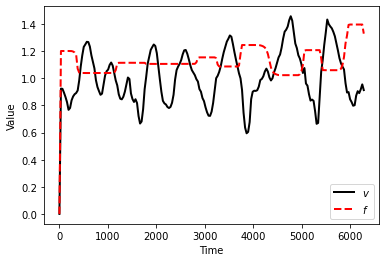

In [23]:
plt.figure(1)
plt.plot(tm,v.value,'k-',lw=2,label=r'$v$')
plt.plot(tm,u.value,'r--',lw=2,label=r'$f$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

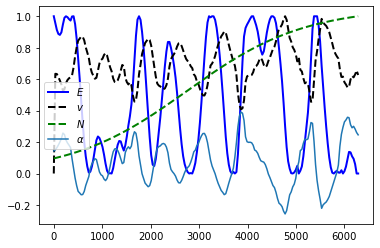

In [24]:
plt.figure(2)
plt.plot(tm,np.array(E.value)/max(E.value),'b-',lw=2,label=r'$E$')
plt.plot(tm,np.array(v.value)/max(v.value),'k--',lw=2,label=r'$v$')
# plt.plot(tm, np.array(sigma.value)/max(sigma.value), 'y-', lw=2, label=r'$\sigma$')
plt.plot(tm, np.array(N.value)/max(N.value), 'g--', lw=2, label=r'$N$')
plt.plot(tm,slope, label=r'$\alpha$')
plt.legend()
plt.show()

In [25]:
6281/3600

1.7447222222222223

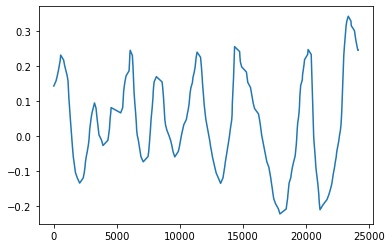

In [26]:
plt.plot(distance_data, grade_data)

In [27]:
E + dE > E0 -> dE=0


SyntaxError: invalid syntax (Temp/ipykernel_14876/4051809826.py, line 1)